## Import Libraries

In [1]:
# Numerical operations
import numpy as np

# Data handling / paths
import os
import shutil
from glob import glob

# Visualization
import matplotlib.pyplot as plt
import cv2  # optional, for advanced image manipulation

# Deep learning / YOLOv8
from ultralytics import YOLO

# Optional: For progress bars in loops
from tqdm import tqdm

# Optional: For Jupyter notebooks
%matplotlib inline
import os
from glob import glob
from warnings import filterwarnings
filterwarnings("ignore")

## Load Dataset

In [2]:
import os
import numpy as np
from glob import glob

def load_dataset(base_path, dataset_name="Dataset"):
    # Paths
    image_path = os.path.join(base_path, "image")
    label_path = os.path.join(base_path, "label")
    
    # Get all .npy files
    img_files = sorted(glob(os.path.join(image_path, "*.npy")))
    label_files = sorted(glob(os.path.join(label_path, "*.npy")))
    
    # Check if files exist
    if len(img_files) == 0 or len(label_files) == 0:
        print(f"{dataset_name} not loaded! Check your folders.")
        return [], []
    
    # Load files
    images = [np.load(f) for f in img_files]
    labels = [np.load(f) for f in label_files]
    
    # Print success info
    print(f"{dataset_name} loaded successfully!")
    print(f"Number of images: {len(images)}")
    print(f"Number of labels/masks: {len(labels)}")
    print(f"Shape of first image: {images[0].shape}, dtype: {images[0].dtype}")
    print(f"Shape of first label: {labels[0].shape}, dtype: {labels[0].dtype}")
    print(f"Unique classes in first mask: {np.unique(labels[0])}")
    
    return images, labels

# Load datasets
train_images, train_labels = load_dataset(r"F:\Research\RoadSegmentation\data\train", "Train Dataset")
val_images, val_labels = load_dataset(r"F:\Research\RoadSegmentation\data\val", "Validation Dataset")


Train Dataset loaded successfully!
Number of images: 2975
Number of labels/masks: 2975
Shape of first image: (128, 256, 3), dtype: float64
Shape of first label: (128, 256), dtype: float64
Unique classes in first mask: [         -1           0           1           2           5           7           8           9          10          11          12          13          18]
Validation Dataset loaded successfully!
Number of images: 500
Number of labels/masks: 500
Shape of first image: (128, 256, 3), dtype: float64
Shape of first label: (128, 256), dtype: float64
Unique classes in first mask: [         -1           0           1           2           4           5           7           8          10          11          13]


## Preview Original and Masked Images

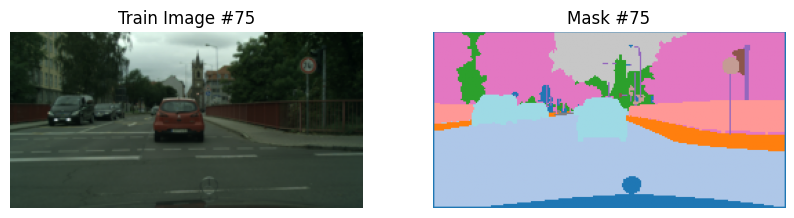

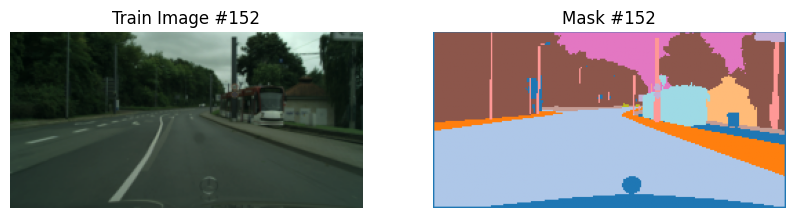

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import random

num_samples = 2

for _ in range(num_samples):
    idx = random.randint(0, len(train_images)-1)
    img = train_images[idx]
    mask = train_labels[idx]

    # Normalize image for display
    img_disp = img - np.min(img)
    img_disp = img_disp / np.max(img_disp)
    img_disp = (img_disp * 255).astype(np.uint8)

    plt.figure(figsize=(10, 5))

    # Show original image
    plt.subplot(1, 2, 1)
    plt.imshow(img_disp)
    plt.title(f"Train Image #{idx}")
    plt.axis("off")

    # Show corresponding mask
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='tab20')
    plt.title(f"Mask #{idx}")
    plt.axis("off")

    plt.show()


### Image and Mask Shapes

In [4]:
# Check shapes of all images and masks
image_shapes = [img.shape for img in train_images]
mask_shapes = [mask.shape for mask in train_labels]

print("Unique image shapes:", set(image_shapes))
print("Unique mask shapes:", set(mask_shapes))
print("Total images:", len(train_images))
print("Total masks:", len(train_labels))

Unique image shapes: {(128, 256, 3)}
Unique mask shapes: {(128, 256)}
Total images: 2975
Total masks: 2975


### Analyze Unique Classes in Masks

In [5]:
# Find all unique classes across all masks
all_classes = set()
for mask in train_labels:
    all_classes.update(np.unique(mask))
print("All unique classes in training masks:", sorted(all_classes))

All unique classes in training masks: [np.float64(-1.0), np.float64(0.0), np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(5.0), np.float64(6.0), np.float64(7.0), np.float64(8.0), np.float64(9.0), np.float64(10.0), np.float64(11.0), np.float64(12.0), np.float64(13.0), np.float64(14.0), np.float64(15.0), np.float64(16.0), np.float64(17.0), np.float64(18.0)]


### # Find all unique classes across all masks

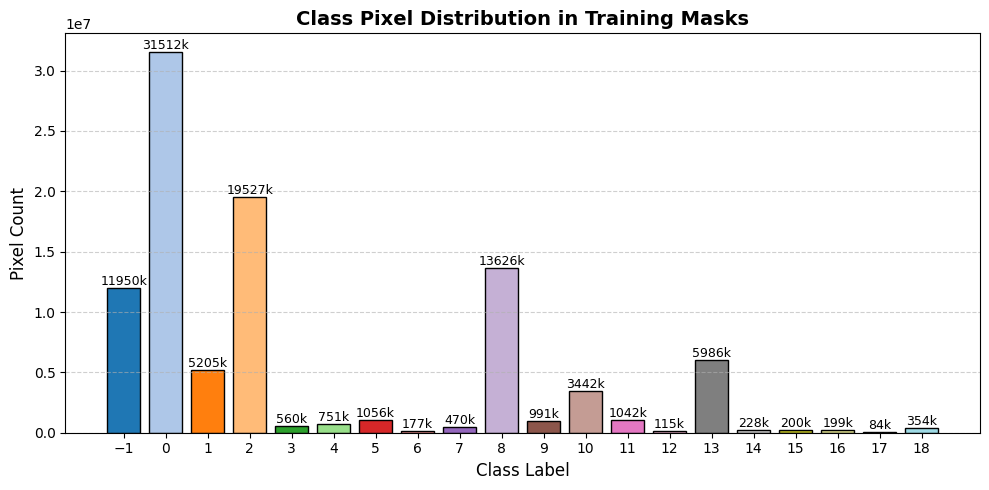

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Count pixel frequency for each class in all masks
class_counter = Counter()
for mask in train_labels:
    vals, counts = np.unique(mask, return_counts=True)
    class_counter.update(dict(zip(vals, counts)))

# Prepare data
classes = sorted(class_counter.keys())
counts = [class_counter[c] for c in classes]

# Color palette (one color per class)
colors = plt.cm.tab20(np.linspace(0, 1, len(classes)))

# Plot
plt.figure(figsize=(10, 5))
bars = plt.bar(classes, counts, color=colors, edgecolor='black')

# Add labels on top of bars
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
             f"{count//1000}k", ha='center', va='bottom', fontsize=9)

# Styling
plt.title("Class Pixel Distribution in Training Masks", fontsize=14, weight='bold')
plt.xlabel("Class Label", fontsize=12)
plt.ylabel("Pixel Count", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.xticks(classes)
plt.tight_layout()
plt.show()


### Check Pixel Value Distribution in Images

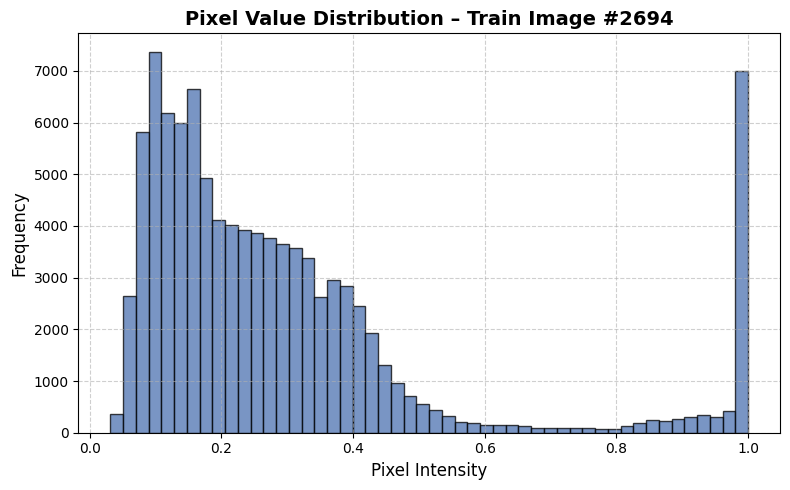

In [7]:
# Random image index
idx = np.random.randint(len(train_images))
img = train_images[idx]

# Flatten pixel values
pixels = img.flatten()

# Plot
plt.figure(figsize=(8, 5))
plt.hist(pixels, bins=50, color='#4C72B0', edgecolor='black', alpha=0.75)
plt.title(f"Pixel Value Distribution – Train Image #{idx}", fontsize=14, weight='bold')
plt.xlabel("Pixel Intensity", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


### Overlay Mask on Image (Random Sample)

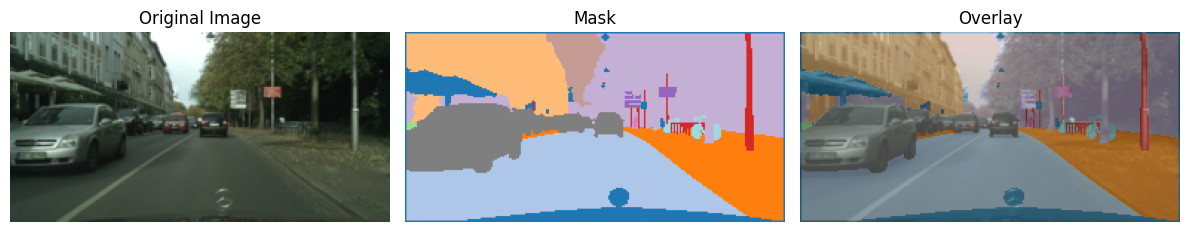

In [8]:
idx = random.randint(0, len(train_images)-1)
img = train_images[idx]
mask = train_labels[idx]

plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(mask, cmap='tab20')
plt.title("Mask")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(img, cmap='gray')
plt.imshow(mask, cmap='tab20', alpha=0.5)
plt.title("Overlay")
plt.axis('off')
plt.tight_layout()
plt.show()

### Class Frequency as Pie Chart

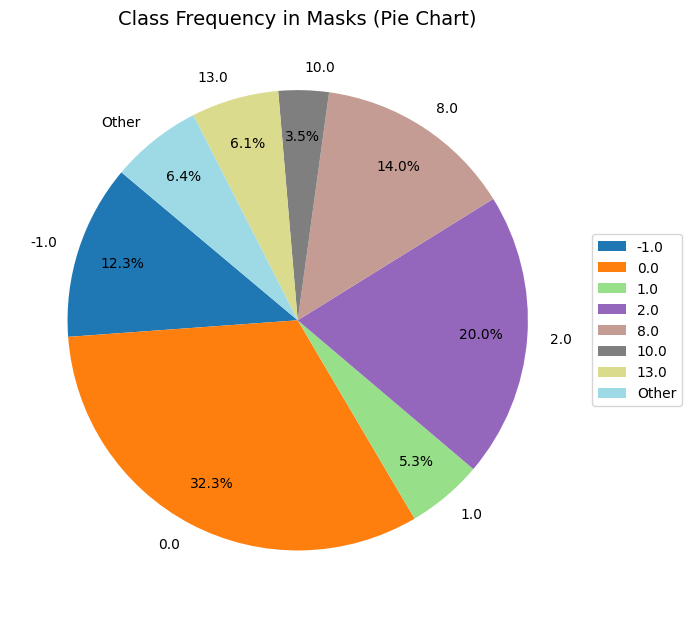

In [9]:
# Only show classes with >2% of total pixels, group others as "Other"
total = sum(counts)
threshold = 0.02 * total
main_classes = [c for c, cnt in zip(classes, counts) if cnt >= threshold]
main_counts = [cnt for cnt in counts if cnt >= threshold]
other_count = sum(cnt for cnt in counts if cnt < threshold)
labels = [str(c) for c in main_classes]
sizes = main_counts
if other_count > 0:
    labels.append("Other")
    sizes.append(other_count)

colors = plt.cm.tab20(np.linspace(0, 1, len(labels)))

plt.figure(figsize=(7,7))
patches, texts, autotexts = plt.pie(
    sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140, pctdistance=0.8
)
plt.title("Class Frequency in Masks (Pie Chart)", fontsize=14)
plt.legend(patches, labels, loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

### Grid of Random Images and Masks

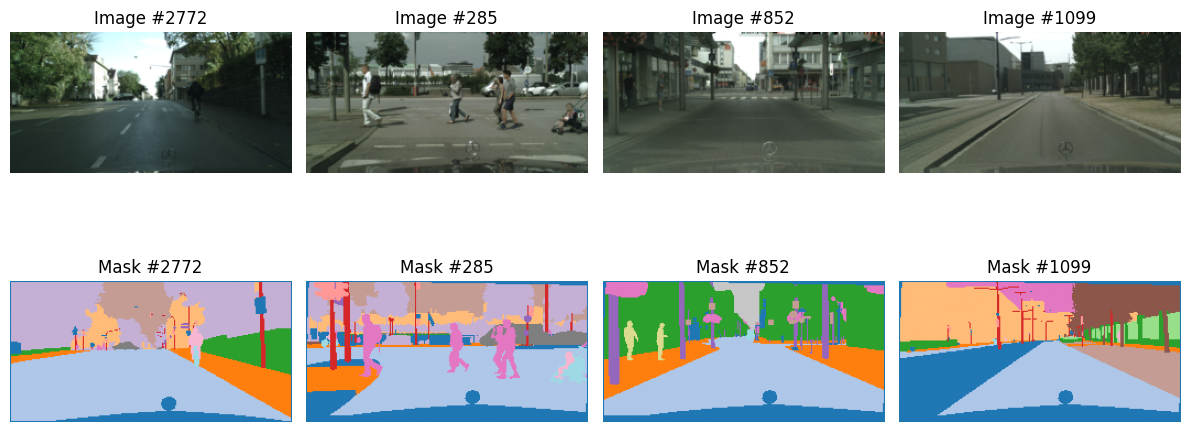

In [10]:
n = 4
plt.figure(figsize=(12, 6))
for i in range(n):
    idx = random.randint(0, len(train_images)-1)
    img = train_images[idx]
    mask = train_labels[idx]
    plt.subplot(2, n, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Image #{idx}")
    plt.axis('off')
    plt.subplot(2, n, n+i+1)
    plt.imshow(mask, cmap='tab20')
    plt.title(f"Mask #{idx}")
    plt.axis('off')
plt.tight_layout()
plt.show()

## Preprocessing

In [11]:
import numpy as np
import cv2

def preprocess_dataset(images, labels, target_size=(256, 512)):
    """
    Preprocess images and labels for segmentation.
    
    Steps:
    1. Normalize images to [0, 1]
    2. Resize images & labels to target_size
    3. Map label IDs to continuous integers starting from 0
    """
    
    # Get all unique classes from the dataset
    all_classes = sorted(set(np.unique(np.concatenate(labels))))
    mapping = {old_id: new_id for new_id, old_id in enumerate(all_classes)}
    print(f"Class Mapping: {mapping}")
    
    processed_images = []
    processed_labels = []
    
    for img, mask in zip(images, labels):
        # Normalize image
        img = img.astype(np.float32) / 255.0
        
        # Resize image
        img_resized = cv2.resize(img, (target_size[1], target_size[0]), interpolation=cv2.INTER_LINEAR)
        
        # Resize mask (nearest neighbor to keep class IDs)
        mask_resized = cv2.resize(mask, (target_size[1], target_size[0]), interpolation=cv2.INTER_NEAREST)
        
        # Remap mask IDs
        mask_mapped = np.vectorize(mapping.get)(mask_resized)
        
        processed_images.append(img_resized)
        processed_labels.append(mask_mapped)
    
    return np.array(processed_images), np.array(processed_labels)

# Example usage:
train_images_p, train_labels_p = preprocess_dataset(train_images, train_labels, target_size=(256, 512))
val_images_p, val_labels_p = preprocess_dataset(val_images, val_labels, target_size=(256, 512))

print("Preprocessing done!")
print("Train set shape:", train_images_p.shape, train_labels_p.shape)
print("Val set shape:", val_images_p.shape, val_labels_p.shape)


Class Mapping: {np.float64(-1.0): 0, np.float64(0.0): 1, np.float64(1.0): 2, np.float64(2.0): 3, np.float64(3.0): 4, np.float64(4.0): 5, np.float64(5.0): 6, np.float64(6.0): 7, np.float64(7.0): 8, np.float64(8.0): 9, np.float64(9.0): 10, np.float64(10.0): 11, np.float64(11.0): 12, np.float64(12.0): 13, np.float64(13.0): 14, np.float64(14.0): 15, np.float64(15.0): 16, np.float64(16.0): 17, np.float64(17.0): 18, np.float64(18.0): 19}
Class Mapping: {np.float64(-1.0): 0, np.float64(0.0): 1, np.float64(1.0): 2, np.float64(2.0): 3, np.float64(3.0): 4, np.float64(4.0): 5, np.float64(5.0): 6, np.float64(6.0): 7, np.float64(7.0): 8, np.float64(8.0): 9, np.float64(9.0): 10, np.float64(10.0): 11, np.float64(11.0): 12, np.float64(12.0): 13, np.float64(13.0): 14, np.float64(14.0): 15, np.float64(15.0): 16, np.float64(16.0): 17, np.float64(17.0): 18, np.float64(18.0): 19}
Preprocessing done!
Train set shape: (2975, 256, 512, 3) (2975, 256, 512)
Val set shape: (500, 256, 512, 3) (500, 256, 512)


## Convert preprocessed arrays → YOLOv8 format (PNG + polygons)

In [12]:
import os, cv2, numpy as np
from pathlib import Path
from PIL import Image

def ensure_dir(p): Path(p).mkdir(parents=True, exist_ok=True)

def save_png(img_arr, out_path):
    # img_arr in [0,1] float or 0-255; convert to uint8 PNG
    if img_arr.dtype != np.uint8:
        arr = np.clip(img_arr, 0, 1) if img_arr.max() <= 1.0 else np.clip(img_arr/255.0, 0, 1)
        arr = (arr*255).astype(np.uint8)
    else:
        arr = img_arr
    Image.fromarray(arr).save(out_path)

def mask_to_yolo_polygons(mask, min_area=25, epsilon_frac=0.01):
    """
    Convert a single-channel label mask (H,W) with class IDs {0..K-1}
    to YOLOv8 segmentation label lines:
      cls x1 y1 x2 y2 ...  (normalized coords in [0,1], clockwise)
    """
    H, W = mask.shape
    lines = []
    classes = np.unique(mask)
    for cls_id in classes:
        if cls_id < 0:  # ignore void if any
            continue
        # binary mask for this class
        binm = (mask == cls_id).astype(np.uint8) * 255
        if binm.sum() == 0:
            continue
        # find contours
        contours, _ = cv2.findContours(binm, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for cnt in contours:
            if cv2.contourArea(cnt) < min_area:
                continue
            # simplify polygon
            eps = epsilon_frac * cv2.arcLength(cnt, True)
            approx = cv2.approxPolyDP(cnt, eps, True).squeeze()
            if approx.ndim != 2 or len(approx) < 3:
                continue
            # normalize x,y
            xs = approx[:,0] / float(W)
            ys = approx[:,1] / float(H)
            poly = np.stack([xs, ys], axis=1).flatten()
            # YOLO wants: cls followed by x y pairs
            line = [int(cls_id)] + poly.tolist()
            lines.append(line)
    return lines

def write_yolo_txt(lines, out_path):
    with open(out_path, "w") as f:
        for line in lines:
            f.write(" ".join(str(v) for v in line) + "\n")

def export_yolo_seg(split_name, images, labels, out_root="data/yolo"):
    img_dir = Path(out_root) / split_name / "images"
    lbl_dir = Path(out_root) / split_name / "labels"
    ensure_dir(img_dir); ensure_dir(lbl_dir)

    for i, (img, mask) in enumerate(zip(images, labels)):
        # filenames
        stem = f"{split_name}_{i:05d}"
        img_path = img_dir / f"{stem}.png"
        lbl_path = lbl_dir / f"{stem}.txt"

        save_png(img, img_path)
        lines = mask_to_yolo_polygons(mask.astype(int))
        write_yolo_txt(lines, lbl_path)

    print(f"[{split_name}] Exported {len(images)} images to {img_dir} and labels to {lbl_dir}")

# ---- Run exports (edit out_root if you want) ----
export_yolo_seg("train", train_images_p, train_labels_p, out_root="RoadSegmentation/data/yolo")
export_yolo_seg("val",   val_images_p,   val_labels_p,   out_root="RoadSegmentation/data/yolo")


[train] Exported 2975 images to RoadSegmentation\data\yolo\train\images and labels to RoadSegmentation\data\yolo\train\labels
[val] Exported 500 images to RoadSegmentation\data\yolo\val\images and labels to RoadSegmentation\data\yolo\val\labels


In [13]:
import numpy as np

all_classes = np.unique(np.concatenate([np.unique(train_labels_p), np.unique(val_labels_p)]))
print("Unique classes:", all_classes)
print("Number of classes:", len(all_classes))


Unique classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Number of classes: 20


## YOLOv8 Model Train

In [14]:
# -----------------------------
# YOLOv8 Segmentation Training
# -----------------------------
from ultralytics import YOLO

# 1️⃣ Load YOLOv8 nano segmentation model (lightweight)
model = YOLO("yolov8n-seg.pt")  # Nano model to fit small GPU

# 2️⃣ Train the model
model.train(
    data=r"F:/Research/RoadSegmentation/NotebookFile/RoadSegmentation/data/yolo/data.yaml",  # path to your data.yaml
    epochs=5,       # number of training epochs
    imgsz=512,       # resize images to 512x512
    batch=4,         # batch size (small for 4GB VRAM)
    device=0,        # use GPU 0
    save=True,       # save weights and checkpoints
    project="RoadSegmentation/runs",  # output folder for logs and weights
    name="yolov8n_seg_train"          # subfolder name
)

# 3️⃣ After training, check results
print("✅ Training completed. Check 'RoadSegmentation/runs/yolov8n_seg_train/' for weights and logs.")


Ultralytics 8.3.179  Python-3.12.10 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce GTX 1650, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=F:/Research/RoadSegmentation/NotebookFile/RoadSegmentation/data/yolo/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8n_seg_train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_

train: Scanning F:\Research\RoadSegmentation\NotebookFile\RoadSegmentation\data\yolo\train\labels.cache... 2975 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2975/2975 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 0.10.2 MB/s, size: 0.6 KB)


val: Scanning F:\Research\RoadSegmentation\NotebookFile\RoadSegmentation\data\yolo\val\labels.cache... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:00<?, ?it/s]


Plotting labels to RoadSegmentation\runs\yolov8n_seg_train2\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 8 dataloader workers
Logging results to RoadSegmentation\runs\yolov8n_seg_train2
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5       1.7G      3.075       4.88      3.947      2.406        295        512: 100%|██████████| 744/744 [04:47<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:22<00:00,  2.75it/s]


                   all        500      22107      0.018     0.0108    0.00738    0.00301     0.0183    0.00981     0.0063     0.0025

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      1.72G      2.818      4.624      3.108      2.234        316        512: 100%|██████████| 744/744 [05:32<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:19<00:00,  3.26it/s]


                   all        500      22107      0.122     0.0093     0.0083    0.00362      0.124    0.00936    0.00842    0.00358

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      1.72G      2.655      4.579      2.814       2.16        149        512: 100%|██████████| 744/744 [05:51<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:29<00:00,  2.16it/s]


                   all        500      22107     0.0762     0.0115     0.0105    0.00526      0.126    0.00991    0.00955     0.0047

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5         2G      2.565      4.552      2.692      2.109        168        512: 100%|██████████| 744/744 [07:19<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:27<00:00,  2.31it/s]


                   all        500      22107      0.122     0.0149      0.012    0.00601      0.226     0.0104     0.0104    0.00506

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.01G      2.501      4.531      2.626      2.072        141        512: 100%|██████████| 744/744 [05:48<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:22<00:00,  2.79it/s]


                   all        500      22107     0.0739     0.0146     0.0114    0.00566     0.0737     0.0123     0.0106    0.00523

5 epochs completed in 0.524 hours.
Optimizer stripped from RoadSegmentation\runs\yolov8n_seg_train2\weights\last.pt, 6.7MB
Optimizer stripped from RoadSegmentation\runs\yolov8n_seg_train2\weights\best.pt, 6.7MB

Validating RoadSegmentation\runs\yolov8n_seg_train2\weights\best.pt...
Ultralytics 8.3.179  Python-3.12.10 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce GTX 1650, 4096MiB)
YOLOv8n-seg summary (fused): 85 layers, 3,261,964 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/63 [00:00<?, ?it/s]

WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   2%|▏         | 1/63 [00:00<00:20,  2.99it/s]

WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   3%|▎         | 2/63 [00:00<00:22,  2.70it/s]

WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 63/63 [00:15<00:00,  4.06it/s]


                   all        500      22107      0.122     0.0149      0.012    0.00602      0.226     0.0104     0.0104    0.00506
                  road        500        500    0.00503      0.022    0.00524    0.00305          0          0          0          0
              sidewalk        483        968    0.00166    0.00413    0.00135   0.000545   0.000995    0.00207   0.000681   0.000178
              building        457       1708          1          0   0.000595   0.000149          1          0    0.00028   5.92e-05
                  wall        491       3709      0.026     0.0113     0.0115    0.00288          1          0    0.00294   0.000611
                 fence        186        561          0          0          0          0          0          0          0          0
                  pole        174        519          0          0          0          0          0          0          0          0
         traffic light        472       3380          0          0   

### Evaluation

In [18]:
from ultralytics import YOLO

# Load the trained best model
model = YOLO(r"F:\Research\RoadSegmentation\NotebookFile\RoadSegmentation\runs\yolov8n_seg_train\weights\best.pt")

# Evaluate on the validation set (images from your data.yaml)
metrics = model.val(
    data=r"F:\Research\RoadSegmentation\NotebookFile\RoadSegmentation\data\yolo\data.yaml",
    batch=4,     # adjust to your GPU memory
    imgsz=512,   # image size used in training
    conf=0.3     # confidence threshold
)

# Print metrics
print(metrics)


Ultralytics 8.3.179  Python-3.12.10 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce GTX 1650, 4096MiB)
YOLOv8n-seg summary (fused): 85 layers, 3,261,964 parameters, 0 gradients, 12.0 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 8.75.9 MB/s, size: 0.8 KB)


val: Scanning F:\Research\RoadSegmentation\NotebookFile\RoadSegmentation\data\yolo\val\labels.cache... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [00:05<00:00, 21.07it/s]


                   all        500      22107     0.0382    0.00863     0.0229     0.0138     0.0389    0.00791     0.0234     0.0135
                  road        500        500    0.00451      0.018     0.0023    0.00145          0          0          0          0
              sidewalk        483        968    0.00465    0.00413    0.00233    0.00134    0.00465    0.00413    0.00233   0.000874
              building        457       1708          0          0          0          0          0          0          0          0
                  wall        491       3709          0          0          0          0          0          0          0          0
                 fence        186        561          0          0          0          0          0          0          0          0
                  pole        174        519          0          0          0          0          0          0          0          0
         traffic light        472       3380          0          0   

In [29]:
from ultralytics import YOLO

# Load your trained model
model = YOLO(r"F:\Research\RoadSegmentation\NotebookFile\RoadSegmentation\runs\yolov8n_seg_train\weights\best.pt")

# Image path
img_path = r"C:\Users\User\Downloads\pexels-joshsorenson-139303.jpg"

# Run inference
results = model(img_path)

# Access the first (and only) result
result = results[0]

# Show results
result.show()  # opens a window displaying the segmented image

# Optionally, save the output
result.save(r"runs/segment/inference_results")  # saves the segmented image in this folder



image 1/1 C:\Users\User\Downloads\pexels-joshsorenson-139303.jpg: 352x512 1 person, 43.5ms
Speed: 6.1ms preprocess, 43.5ms inference, 4.4ms postprocess per image at shape (1, 3, 352, 512)


'runs/segment/inference_results'